In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 准备并处理数据

### 1.1 准备数据

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target,)
#                                                             random_state= 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, )
#                                                       random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 1.2 数据归一化

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. 建立模型

In [5]:
# 使用sklearn中的RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索超参数

def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation="relu",                                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train, epochs=100, 
                  validation_data = (x_valid_scaled, y_valid),
                  callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 83us/sample - loss: 1.2016 - val_loss: 0.6244
Epoch 2/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6123 - val_loss: 0.5464
Epoch 3/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5419 - val_loss: 0.5180
Epoch 4/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5186 - val_loss: 0.5119
Epoch 5/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5320 - val_loss: 0.4797
Epoch 6/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4876 - val_loss: 0.4762
Epoch 7/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4899 - val_loss: 0.4594
Epoch 8/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4657 - val_loss: 0.4537
Epoch 9/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.457

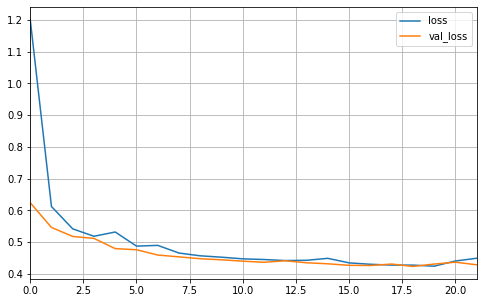

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
#     plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 3.【重点】包装模型

In [7]:
from scipy.stats import reciprocal
param_distribution = {
    "hidden_layers": [1, 2],
    "layer_size": range(10),
    "learning_rate": [1e-4, 1e-3, 1e-2] # reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model,
                                     param_distribution,
                                     n_iter = 3,  # 参数采样数
                                     cv = 3,  # 交叉验证分的份数
                                     n_jobs = 1)  # 使用cpu数量
random_search_cv.fit(x_train_scaled, y_train, epochs=5, 
                     validation_data = (x_valid_scaled, y_valid), 
                     callbacks=callbacks)

Train on 7740 samples, validate on 3870 samples
Epoch 1/5
7740/7740 [==============================] - 0s 63us/sample - loss: 3.1943 - val_loss: 1.9074
Epoch 2/5
7740/7740 [==============================] - 0s 38us/sample - loss: 1.5039 - val_loss: 1.1982
Epoch 3/5
7740/7740 [==============================] - 0s 37us/sample - loss: 1.0733 - val_loss: 0.9898
Epoch 4/5
7740/7740 [==============================] - 0s 37us/sample - loss: 0.9419 - val_loss: 0.9021
Epoch 5/5
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8785 - val_loss: 0.8460
3870/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026E23E51E48>,
                   iid='deprecated', n_iter=3, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2],
                                        'layer_size': range(0, 10),
                                        'learning_rate': [0.0001, 0.001, 0.01]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [8]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'learning_rate': 0.01, 'layer_size': 1, 'hidden_layers': 2}
-0.5552261161609111


## 4. 提取模型

In [9]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1.3709158195081608